In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os,sys
from PIL import Image
import talos as ta
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Loading the dataset

In [5]:
import helper

In [6]:
# Loaded a set of images
root_dir = "Datasets/training/"

n = 100

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
print("Loading " + str(n) + " images")
imgs = [helper.load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [helper.load_image(gt_dir + files[i]) for i in range(n)]

Loading 100 images
Loading 100 images


In [7]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [helper.img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [helper.img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

## Feture processing 

In [8]:
#TODO

# CNN

In [9]:
from tensorflow.keras import datasets, layers, models

## Layers

In [42]:
p = {'lr': (0.5, 5, 10),
     'first_neuron':[4, 8, 16, 32, 64],
     'hidden_layers':[0, 1, 2],
     'batch_size': (2, 30, 10),
     'epochs': [5],
     'dropout': (0, 0.5, 5),
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'shape':['brick','long_funnel'],
     'optimizer': ['adam', 'nadam'],
     'losses': ['logcosh', 'binary_crossentropy'],
     'activation':['relu', 'elu'],
     'last_activation': ['sigmoid']}

In [48]:
def road_seg_model(x_train, y_train, x_val, y_val, params):
    model = models.Sequential()
    
    model.add(layers.Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation=params['activation']))
    
    model.add(layers.Dropout(params['dropout']))

    model.add(layers.Dense(1, activation=params['last_activation']))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'],
                  metrics=['acc', ta.utils.metrics.f1score])
    
    model.add(layers.Dense(1, activation=params['last_activation']))

    y = helper.patches_labelization(gt_patches)

    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optimizer'])),
                  metrics=['acc', fmeasure])
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0)
    return history, model

In [49]:
t = ta.Scan(x=img_patches,
            y=gt_patches,
            model=road_seg_model, 
            params=p,
           experiment_name ='road' )















  0%|          | 0/120000 [00:00<?, ?it/s]

OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## Training

Train on 56250 samples, validate on 6250 samples
Epoch 1/3
56250/56250 [==============================] - 14s 247us/sample - loss: 0.5790 - accuracy: 0.6838 - val_loss: 0.5534 - val_accuracy: 0.6910
Epoch 2/3
56250/56250 [==============================] - 15s 270us/sample - loss: 0.5252 - accuracy: 0.7256 - val_loss: 0.5584 - val_accuracy: 0.6725
Epoch 3/3
56250/56250 [==============================] - 14s 249us/sample - loss: 0.4883 - accuracy: 0.7559 - val_loss: 0.4927 - val_accuracy: 0.7469


## Predictions

In [30]:
predictions = model.predict(img_patches)

In [31]:
predictions = np.squeeze(helper.binarize_predictions(predictions))

### Displaying predictions

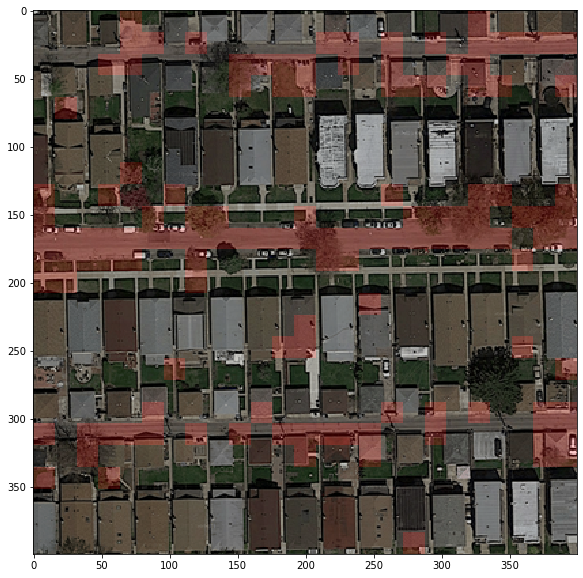

In [32]:
# Display prediction as an image
img_idx = 17

img_indexed = imgs[img_idx]
img_pat = helper.img_crop(img_indexed, patch_size, patch_size)
img_pat = np.asarray(img_pat)
prediction = model.predict(img_pat)

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = helper.label_to_img(w, h, patch_size, patch_size, helper.binarize_predictions(prediction))
cimg = helper.concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = helper.make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

# Create Submission

In [33]:
import submission as sub

In [34]:
n = 50
patch_size = 16 

img_test = []

for i in range(1, 51):
    image_filename = 'Datasets/test_set_images/test_' + str(i) + '/test_' + str(i) + '.png' 
    img_test.append(helper.load_image(image_filename))

img_patches_test = [helper.img_crop(img_test[i], patch_size, patch_size) for i in range(n)]
img_patches_test = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))])

In [35]:
predictions = model.predict(img_patches_test)
predictions = np.squeeze(helper.binarize_predictions(predictions))

In [36]:
sub.create_pred_images(predictions)

In [37]:
submission_filename = 'submission.csv'
   
sub.create_submission(submission_filename)

File 'submission.csv' created
